In [ ]:
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from collections import Counter
import matplotlib.pyplot as plt
import re
import numpy as np
import os
import matplotlib.pyplot as plt


# Transactions

Intrinsic

In [525]:
intr = pd.read_csv("transactions/evaluation_res/transactions_dbscan_intrinsic_scores_kgrid_test.csv")

In [526]:
display(intr)

,label_col,min_samples,eps_value,core_size,n_clusters,coverage,silhouette_core,davies_bouldin_core,calinski_harabasz_core
0,dbscan_ms5_p70_eps_0.065341,5,0.065341,158030,160,0.765460,0.445007,0.980459,5269.823245
1,dbscan_ms5_p80_eps_0.076604,5,0.076604,178167,149,0.862999,0.365052,1.036693,4837.346875
2,dbscan_ms5_p85_eps_0.083165,5,0.083165,186496,146,0.903343,0.502767,1.023748,4780.311989
3,dbscan_ms5_p90_eps_0.091667,5,0.091667,194103,138,0.940189,0.354314,1.160421,3981.432069
4,dbscan_ms5_p95_eps_0.105537,5,0.105537,200642,92,0.971863,0.408680,1.172812,4609.480481
5,dbscan_ms10_p70_eps_0.070407,10,0.070407,164897,95,0.798722,0.656343,0.939887,9719.650840
6,dbscan_ms10_p80_eps_0.082346,10,0.082346,183688,81,0.889741,0.606336,0.975981,9743.819756
7,dbscan_ms10_p85_eps_0.089368,10,0.089368,190912,77,0.924733,0.564953,0.956979,9184.478642
8,dbscan_ms10_p90_eps_0.098640,10,0.098640,196987,76,0.954159,0.503161,1.070636,7545.523264
9,dbscan_ms10_p95_eps_0.114164,10,0.114164,201993,58,0.978406,0.456874,1.200752,7378.365370


In [527]:
eps_col = "eps_value" if "eps_value" in intr.columns else "eps"

has_ms = "min_samples" in intr.columns and intr["min_samples"].notna().any()
groups = intr.groupby("min_samples") if has_ms else [(None, intr)]

In [528]:
def minmax(x):
    x = x.astype(float)
    r = x.max() - x.min()
    return (x - x.min())/r if r != 0 else pd.Series(np.zeros_like(x), index=x.index)

intr["sil_norm"] = minmax(intr["silhouette_core"])
intr["dbi_norm"] = 1 - minmax(intr["davies_bouldin_core"])
intr["ch_norm"]  = minmax(intr["calinski_harabasz_core"])

def plot_metric(metric_col, ylabel, title):
    plt.figure(figsize=(7,5))
    for ms, df in groups:
        df = df.sort_values(eps_col)
        df = df[np.isfinite(df[eps_col]) & np.isfinite(df[metric_col])]
        if df.empty:
            continue
        label = f"ms={int(ms)}" if ms is not None and not np.isnan(ms) else None
        plt.plot(df[eps_col], df[metric_col], marker="o", label=label)
    plt.xlabel("eps")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, which="both", axis="both")
    if has_ms:
        plt.legend(title="min_samples")
    plt.tight_layout()
    plt.show()

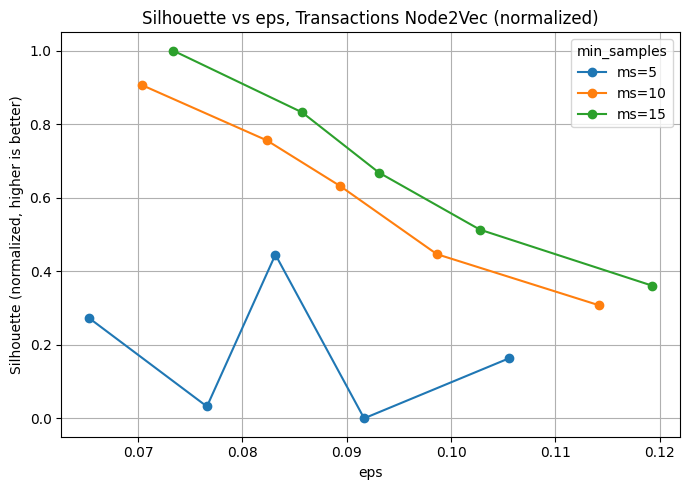

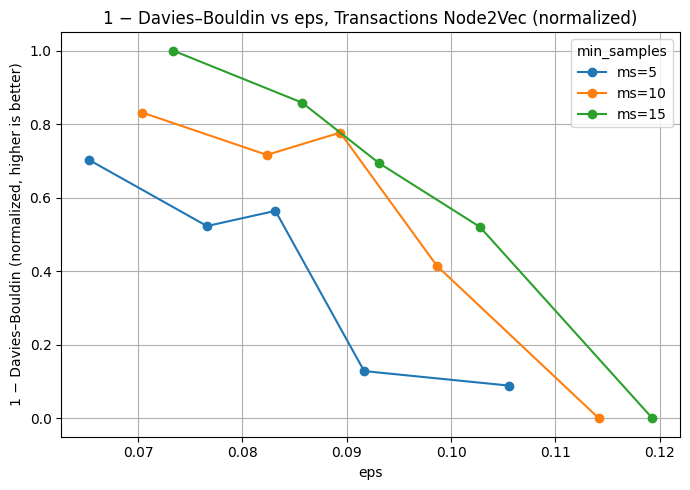

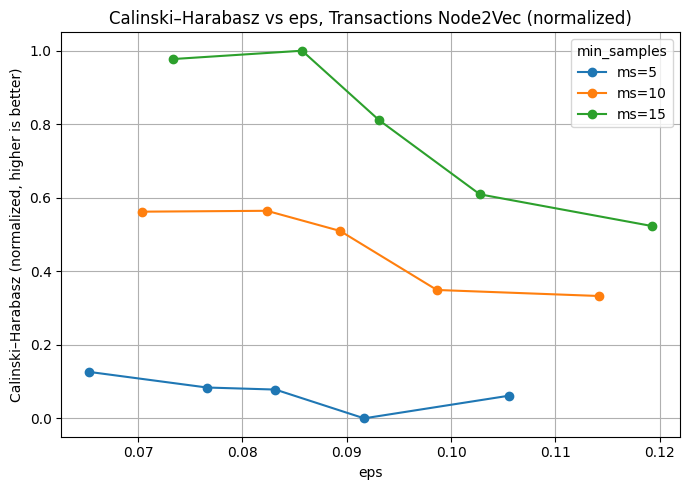

In [529]:
plot_metric("sil_norm",
            "Silhouette (normalized, higher is better)",
            "Silhouette vs eps, Transactions Node2Vec (normalized)")

plot_metric("dbi_norm",
            "1 − Davies–Bouldin (normalized, higher is better)",
            "1 − Davies–Bouldin vs eps, Transactions Node2Vec (normalized)")

plot_metric("ch_norm",
            "Calinski–Harabasz (normalized, higher is better)",
            "Calinski–Harabasz vs eps, Transactions Node2Vec (normalized)")

In [530]:
CORE_MIN = 500
COV_MIN, COV_MAX = 0.05, 0.80  

In [532]:
def plot_internal_all(intr, title_prefix):
    eps_col = "eps_value" if "eps_value" in intr.columns else "eps"
    has_ms = "min_samples" in intr.columns and intr["min_samples"].notna().any()
    groups = intr.groupby("min_samples") if has_ms else [(None, intr)]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
    metrics = [
        ("sil_norm", "Silhouette (normalized)"),
        ("dbi_norm", "1 – Davies–Bouldin (normalized)"),
        ("ch_norm",  "Calinski–Harabasz (normalized)"),
    ]

    for ax, (mcol, ylabel) in zip(axes, metrics):

        for ms, df in groups:
            df = df.sort_values(eps_col)
            df = df[np.isfinite(df[eps_col]) & np.isfinite(df[mcol])]
            if df.empty:
                continue
            label = f"ms={int(ms)}" if ms is not None and not np.isnan(ms) else None
            ax.plot(df[eps_col], df[mcol], marker="o", label=label, alpha=0.8)

        ax.set_xlabel("eps")
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3)

        # annotate best
        metric_vals = intr[mcol].astype(float)
        mask = np.isfinite(intr[eps_col]) & np.isfinite(metric_vals)
        if mask.any():
            best_idx = metric_vals[mask].idxmax()
            best_row = intr.loc[best_idx]

            x_best = best_row[eps_col]
            y_best = best_row[mcol]
            ms_best = best_row["min_samples"] if "min_samples" in intr.columns else None

            if ms_best is not None and not np.isnan(ms_best):
                text = f"ms={int(ms_best)}, ε={x_best:.3f}"
            else:
                text = f"ε={x_best:.3f}"

            # offset 
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            xr = xmax - xmin
            yr = ymax - ymin

            tx = (x_best - xmin) / xr if xr != 0 else 0.5
            ty = (y_best - ymin) / yr if yr != 0 else 0.5

            if tx > 0.66:
                dx = -18
            elif tx < 0.33:
                dx = 18
            else:
                dx = 0

            if ty > 0.66:
                dy = -10
            elif ty < 0.33:
                dy = 10
            else:
                dy = 6 

            ax.annotate(
                text,
                xy=(x_best, y_best),
                xytext=(dx, dy),
                textcoords="offset points",
                ha="center",
                fontsize=9,
                bbox=dict(boxstyle="round,pad=0.2",
                          fc="white", ec="none", alpha=0.7)
            )

    axes[0].set_title(f"{title_prefix} — Silhouette")
    axes[1].set_title(f"{title_prefix} — 1 − DB Index")
    axes[2].set_title(f"{title_prefix} — Calinski–Harabasz")

    if has_ms:
        axes[-1].legend(title="min_samples", bbox_to_anchor=(1.05, 1), loc="upper left")

    fig.suptitle(f"{title_prefix} — DBSCAN Internal Evaluation", y=1.03)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


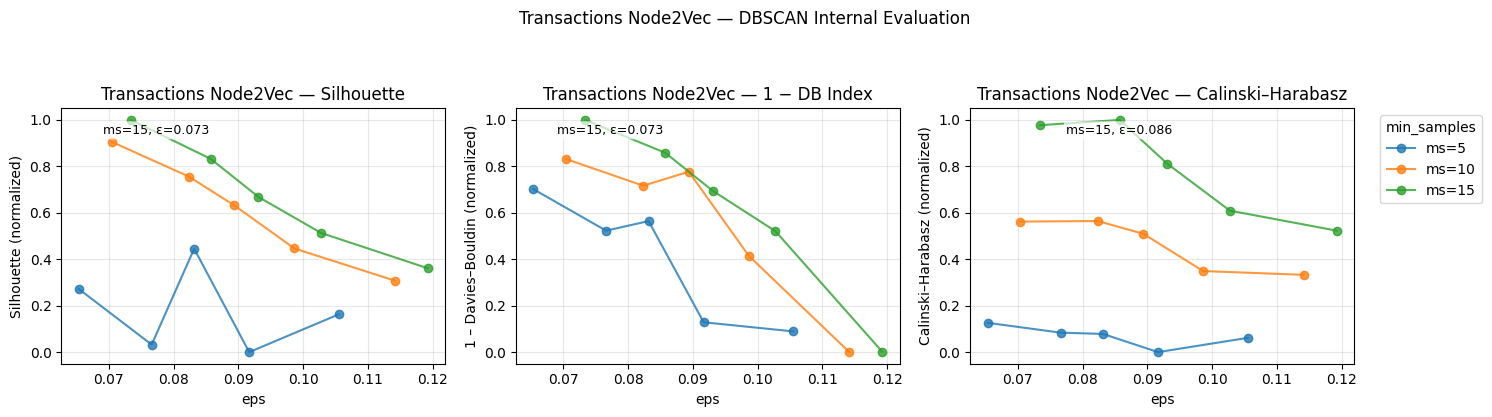

In [533]:
plot_internal_all(intr, title_prefix="Transactions Node2Vec")

Extrinsic

In [534]:
extr = pd.read_csv("transactions/evaluation_res/transactions_dbscan_extrinsic_scores_kgrid_test.csv")

In [535]:
display(extr)

,label_col,min_samples,eps_value,core_size,coverage,n_clusters,ARI_masked,NMI_masked,Purity_masked,ARI_strict,NMI_strict
0,dbscan_ms5_p70_eps_0.065341,5,0.065341,286,0.720403,27,-0.050626,0.231654,0.825175,-0.070180,0.230270
1,dbscan_ms5_p80_eps_0.076604,5,0.076604,300,0.755668,24,-0.035193,0.252940,0.816667,-0.044958,0.245919
2,dbscan_ms5_p85_eps_0.083165,5,0.083165,308,0.775819,23,-0.032485,0.249196,0.818182,-0.036661,0.250702
3,dbscan_ms5_p90_eps_0.091667,5,0.091667,317,0.798489,27,-0.005439,0.242252,0.820189,0.004713,0.257334
4,dbscan_ms5_p95_eps_0.105537,5,0.105537,327,0.823678,21,0.000206,0.217512,0.813456,0.034377,0.251965
5,dbscan_ms10_p70_eps_0.070407,10,0.070407,274,0.690176,22,-0.048365,0.246384,0.817518,-0.070994,0.229631
6,dbscan_ms10_p80_eps_0.082346,10,0.082346,289,0.727960,17,-0.042161,0.232074,0.813149,-0.055500,0.228819
7,dbscan_ms10_p85_eps_0.089368,10,0.089368,294,0.740554,16,-0.034177,0.240666,0.812925,-0.046093,0.237512
8,dbscan_ms10_p90_eps_0.098640,10,0.098640,303,0.763224,19,-0.024418,0.234907,0.811881,-0.030398,0.237043
9,dbscan_ms10_p95_eps_0.114164,10,0.114164,320,0.806045,14,-0.004467,0.190161,0.806250,0.027687,0.226558


------------
Intrinsic best -> ms=10, eps=0.070407. 

Extrinsic best -> ms=5, eps=0.091667

selection -> ms=10, eps=0.098640

---------

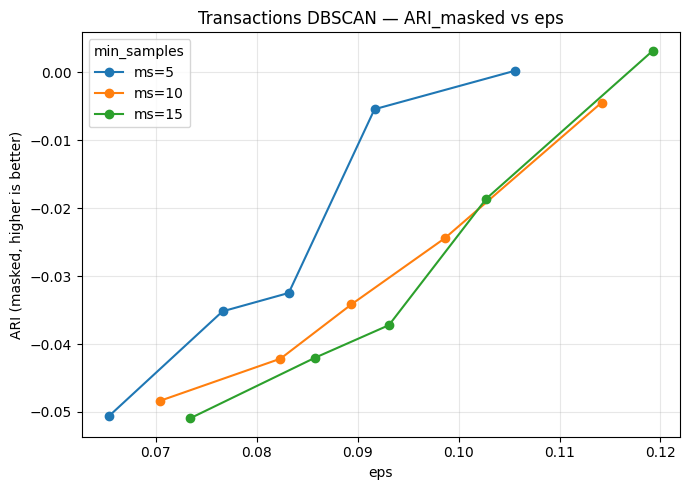

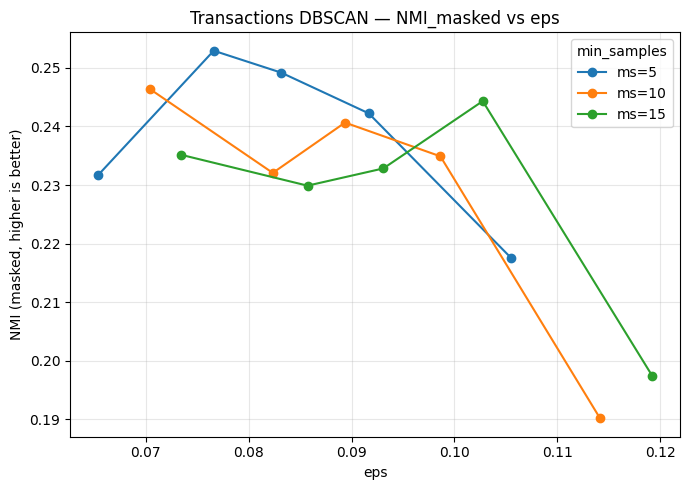

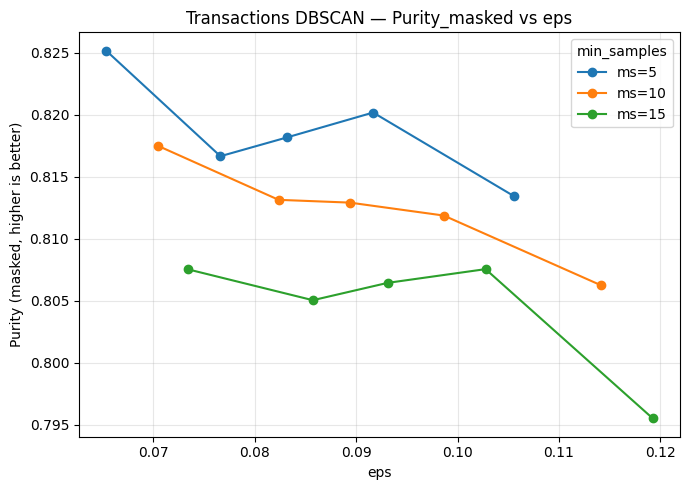

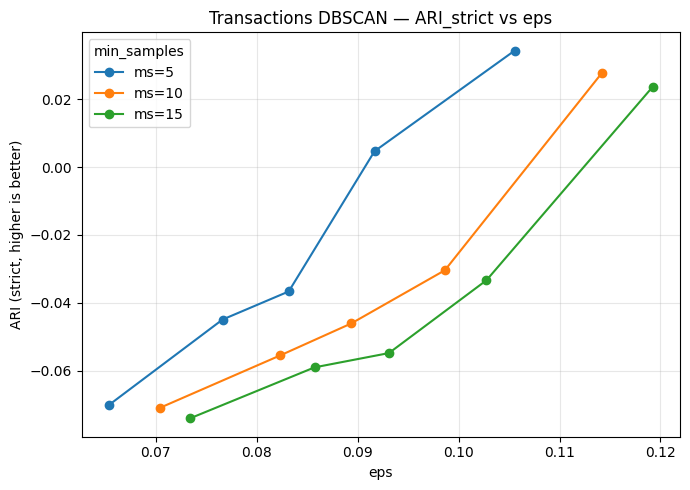

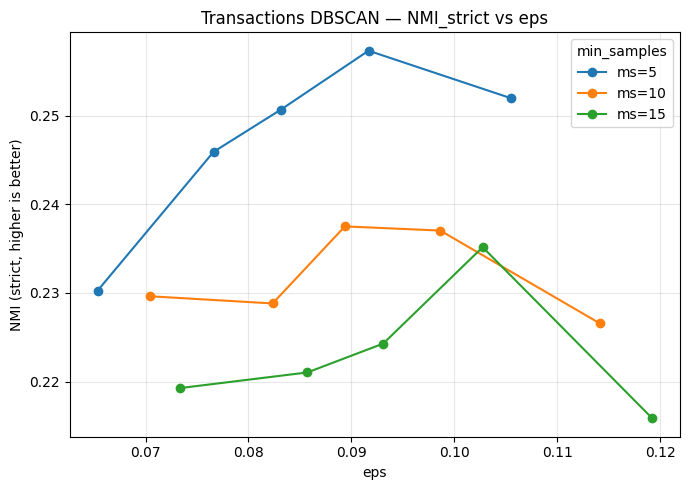

In [ ]:

extr = pd.read_csv("transactions/evaluation_res/transactions_dbscan_extrinsic_scores_kgrid_test.csv")

eps_col = "eps_value" if "eps_value" in extr.columns else "eps"

has_ms = "min_samples" in extr.columns and extr["min_samples"].notna().any()
groups = extr.groupby("min_samples") if has_ms else [(None, extr)]

def plot_metric(metric_col, ylabel, title):
    plt.figure(figsize=(7,5))
    for ms, df in groups:
        df = df.sort_values(eps_col)
        df = df[np.isfinite(df[eps_col]) & np.isfinite(df[metric_col])]
        if df.empty:
            continue
        label = f"ms={int(ms)}" if ms is not None and not np.isnan(ms) else None
        plt.plot(df[eps_col], df[metric_col], marker="o", label=label)
    plt.xlabel("eps")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, which="both", axis="both", alpha=0.3)
    if has_ms:
        plt.legend(title="min_samples")
    plt.tight_layout()
    plt.show()

plot_metric("ARI_masked",
            "ARI (masked, higher is better)",
            "Transactions DBSCAN — ARI_masked vs eps")

plot_metric("NMI_masked",
            "NMI (masked, higher is better)",
            "Transactions DBSCAN — NMI_masked vs eps")

plot_metric("Purity_masked",
            "Purity (masked, higher is better)",
            "Transactions DBSCAN — Purity_masked vs eps")



plot_metric("ARI_strict",
            "ARI (strict, higher is better)",
            "Transactions DBSCAN — ARI_strict vs eps")

plot_metric("NMI_strict",
            "NMI (strict, higher is better)",
            "Transactions DBSCAN — NMI_strict vs eps")


In [538]:
def plot_external_all(extr, title_prefix):
    eps_col = "eps_value" if "eps_value" in extr.columns else "eps"
    has_ms = "min_samples" in extr.columns and extr["min_samples"].notna().any()
    groups = extr.groupby("min_samples") if has_ms else [(None, extr)]

    fig = plt.figure(figsize=(18, 8))

    # Top 
    ax1 = plt.subplot(2, 3, 1)
    ax2 = plt.subplot(2, 3, 2)
    ax3 = plt.subplot(2, 3, 3)

    # Bottom
    ax4 = plt.subplot(2, 3, 4)
    ax5 = plt.subplot(2, 3, 5)

    top_metrics = [
        (ax1, "ARI_masked",   "ARI (masked)"),
        (ax2, "NMI_masked",   "NMI (masked)"),
        (ax3, "Purity_masked","Purity (masked)"),
    ]

    bottom_metrics = [
        (ax4, "ARI_strict",   "ARI (strict)"),
        (ax5, "NMI_strict",   "NMI (strict)"),
    ]

    all_metrics = top_metrics + bottom_metrics

    for ax, mcol, ylabel in all_metrics:

        for ms, df in groups:
            df = df.sort_values(eps_col)
            df = df[np.isfinite(df[eps_col]) & np.isfinite(df[mcol])]
            if df.empty:
                continue
            label = f"ms={int(ms)}" if ms is not None and not np.isnan(ms) else None
            ax.plot(df[eps_col], df[mcol], marker="o", label=label, alpha=0.8)

        ax.set_xlabel("eps")
        ax.set_ylabel(ylabel)
        ax.set_title(f"{title_prefix} — {ylabel}")
        ax.grid(True, alpha=0.3)

        # annotate best
        metric_vals = extr[mcol].astype(float)
        mask = np.isfinite(extr[eps_col]) & np.isfinite(metric_vals)
        if mask.any():
            best_idx = metric_vals[mask].idxmax()
            best_row = extr.loc[best_idx]

            x_best = best_row[eps_col]
            y_best = best_row[mcol]
            ms_best = best_row["min_samples"] if "min_samples" in extr.columns else None

            if ms_best is not None and not np.isnan(ms_best):
                text = f"ms={int(ms_best)}, ε={x_best:.3f}"
            else:
                text = f"ε={x_best:.3f}"

           
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            xr = xmax - xmin
            yr = ymax - ymin

          
            tx = (x_best - xmin) / xr if xr != 0 else 0.5
            ty = (y_best - ymin) / yr if yr != 0 else 0.5

            
            if tx > 0.66:
                dx = -20  
            elif tx < 0.33:
                dx = 20   
            else:
                dx = 0 

           
            if ty > 0.66:
                dy = -10 
            elif ty < 0.33:
                dy = 10 
            else:
                dy = 6 

            ax.annotate(
                text,
                xy=(x_best, y_best),
                xytext=(dx, dy),
                textcoords="offset points",
                ha="center",
                fontsize=9,
                bbox=dict(boxstyle="round,pad=0.2",
                          fc="white", ec="none", alpha=0.7)
            )

    if has_ms:
        ax5.legend(title="min_samples", bbox_to_anchor=(1.05, 1), loc="upper left")

    fig.suptitle(f"{title_prefix} — DBSCAN External Evaluation", fontsize=14, y=0.97)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


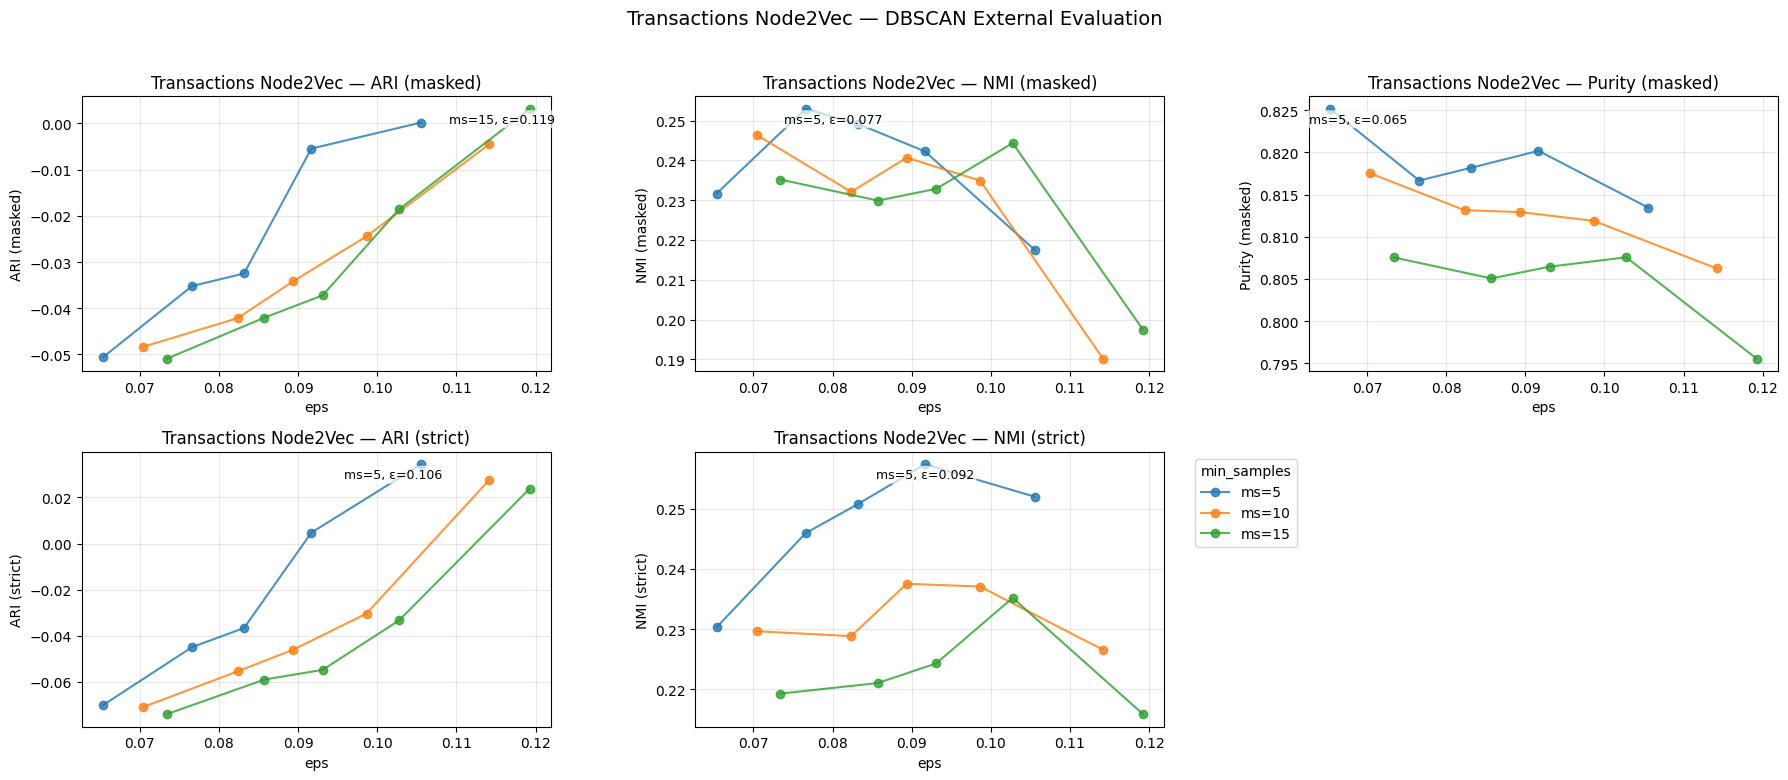

In [539]:
plot_external_all(extr, title_prefix="Transactions Node2Vec")

## Trustlines

Intrinsic

In [540]:
intr = pd.read_csv("trustlines/evaluation_res/trustlines_dbscan_intrinsic_scores_kgrid_test.csv")

In [541]:
display(intr)

,label_col,min_samples,eps_value,core_size,n_clusters,coverage,silhouette_core,davies_bouldin_core,calinski_harabasz_core
0,dbscan_ms5_p70_eps_0.127877,5,0.127877,19656,69,0.799479,-0.428723,1.265250,11.390580
1,dbscan_ms5_p80_eps_0.152065,5,0.152065,21663,50,0.881111,-0.364770,1.295510,11.645063
2,dbscan_ms5_p85_eps_0.168134,5,0.168134,22542,35,0.916863,-0.307969,1.315956,12.211853
3,dbscan_ms5_p90_eps_0.190112,5,0.190112,23448,19,0.953713,-0.260953,1.288338,11.285422
4,dbscan_ms5_p95_eps_0.220959,5,0.220959,24131,12,0.981494,-0.211889,1.265210,10.088073
5,dbscan_ms10_p70_eps_0.148969,10,0.148969,20683,23,0.841251,-0.256518,1.281808,17.307281
6,dbscan_ms10_p80_eps_0.176786,10,0.176786,22443,21,0.912837,-0.210110,1.314782,19.229635
7,dbscan_ms10_p85_eps_0.195421,10,0.195421,23273,17,0.946596,-0.203566,1.294433,17.873976
8,dbscan_ms10_p90_eps_0.220021,10,0.220021,23906,7,0.972342,-0.130152,1.341800,16.211934
9,dbscan_ms10_p95_eps_0.254348,10,0.254348,24346,3,0.990238,-0.028237,1.167331,22.847078


In [542]:
eps_col = "eps_value" if "eps_value" in intr.columns else "eps"

has_ms = "min_samples" in intr.columns and intr["min_samples"].notna().any()
groups = intr.groupby("min_samples") if has_ms else [(None, intr)]

In [544]:
def minmax(x):
    x = x.astype(float)
    r = x.max() - x.min()
    return (x - x.min())/r if r != 0 else pd.Series(np.zeros_like(x), index=x.index)

intr["sil_norm"] = minmax(intr["silhouette_core"])
intr["dbi_norm"] = 1 - minmax(intr["davies_bouldin_core"])
intr["ch_norm"]  = minmax(intr["calinski_harabasz_core"])

def plot_metric(metric_col, ylabel, title):
    plt.figure(figsize=(7,5))
    for ms, df in groups:
        df = df.sort_values(eps_col)
        df = df[np.isfinite(df[eps_col]) & np.isfinite(df[metric_col])]
        if df.empty:
            continue
        label = f"ms={int(ms)}" if ms is not None and not np.isnan(ms) else None
        plt.plot(df[eps_col], df[metric_col], marker="o", label=label)
    plt.xlabel("eps")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, which="both", axis="both")
    if has_ms:
        plt.legend(title="min_samples")
    plt.tight_layout()
    plt.show()

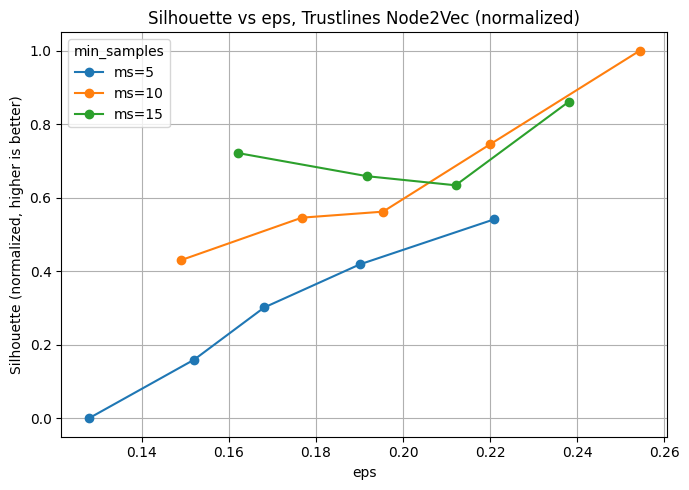

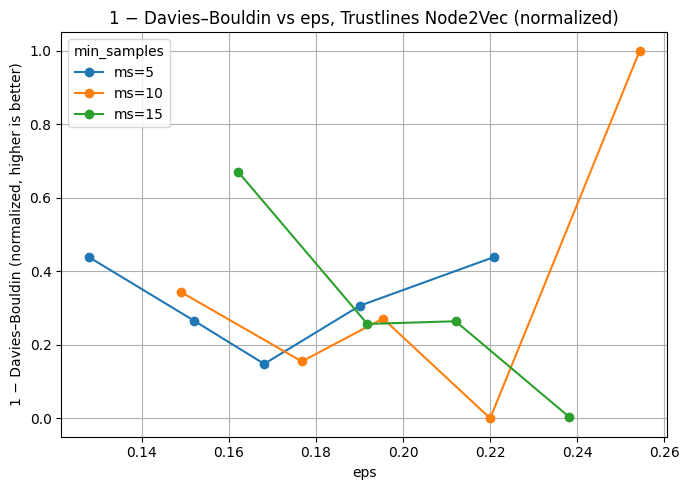

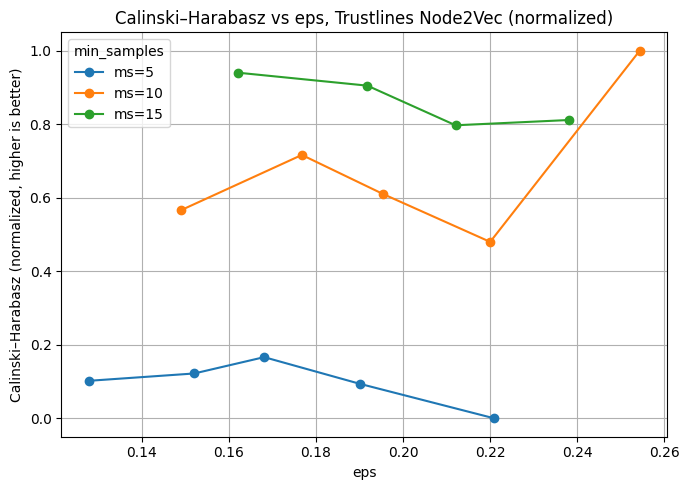

In [545]:
plot_metric("sil_norm",
            "Silhouette (normalized, higher is better)",
            "Silhouette vs eps, Trustlines Node2Vec (normalized)")

plot_metric("dbi_norm",
            "1 − Davies–Bouldin (normalized, higher is better)",
            "1 − Davies–Bouldin vs eps, Trustlines Node2Vec (normalized)")

plot_metric("ch_norm",
            "Calinski–Harabasz (normalized, higher is better)",
            "Calinski–Harabasz vs eps, Trustlines Node2Vec (normalized)")

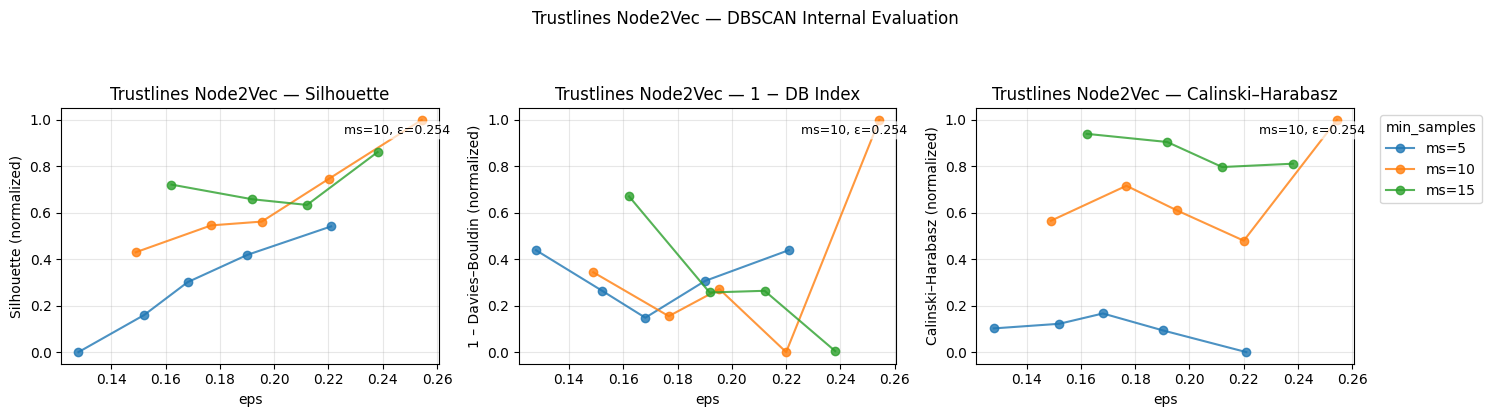

In [548]:
plot_internal_all(intr, title_prefix="Trustlines Node2Vec")

Extrinsic

In [549]:
extr = pd.read_csv("trustlines/evaluation_res/trustlines_dbscan_extrinsic_scores_kgrid_test.csv")

In [550]:
display(extr)

,label_col,min_samples,eps_value,core_size,coverage,n_clusters,ARI_masked,NMI_masked,Purity_masked,ARI_strict,NMI_strict
0,dbscan_ms5_p70_eps_0.127877,5,0.127877,114,0.820144,5,0.248307,0.296980,0.912281,0.192812,0.261442
1,dbscan_ms5_p80_eps_0.152065,5,0.152065,123,0.884892,4,0.260447,0.290481,0.902439,0.230135,0.273188
2,dbscan_ms5_p85_eps_0.168134,5,0.168134,128,0.920863,4,0.267198,0.285178,0.898438,0.258702,0.280818
3,dbscan_ms5_p90_eps_0.190112,5,0.190112,135,0.971223,2,0.167304,0.190336,0.874074,0.103996,0.171348
4,dbscan_ms5_p95_eps_0.220959,5,0.220959,137,0.985612,2,0.167786,0.190332,0.875912,0.133584,0.177990
5,dbscan_ms10_p70_eps_0.148969,10,0.148969,115,0.827338,1,0.000000,0.000000,0.904348,0.171135,0.147653
6,dbscan_ms10_p80_eps_0.176786,10,0.176786,126,0.906475,1,0.000000,0.000000,0.896825,0.211865,0.172791
7,dbscan_ms10_p85_eps_0.195421,10,0.195421,129,0.928058,1,0.000000,0.000000,0.891473,0.191386,0.157821
8,dbscan_ms10_p90_eps_0.220021,10,0.220021,132,0.949640,1,0.000000,0.000000,0.893939,0.246206,0.193290
9,dbscan_ms10_p95_eps_0.254348,10,0.254348,137,0.985612,1,0.000000,0.000000,0.868613,-0.024685,0.005082


------------
Intrinsic best -> negative not good  

Extrinsic best -> ms=5, eps=0.168134

selection -> ms = 5, eps ≈ 0.168

---------

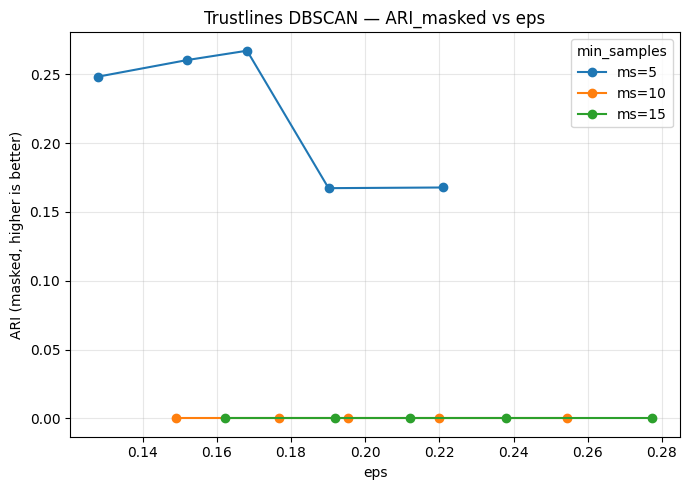

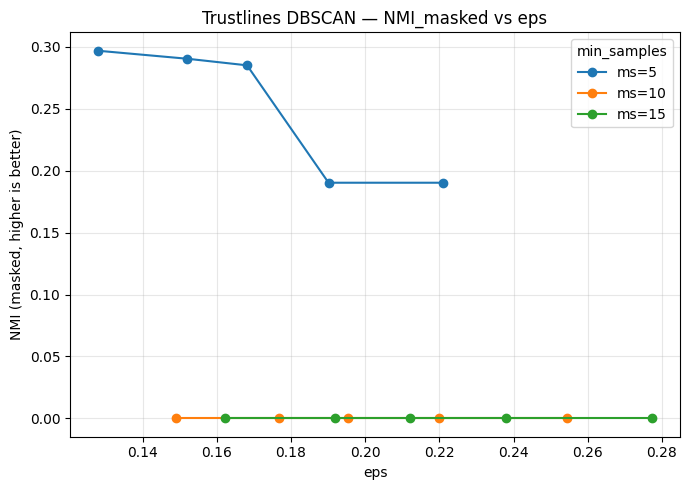

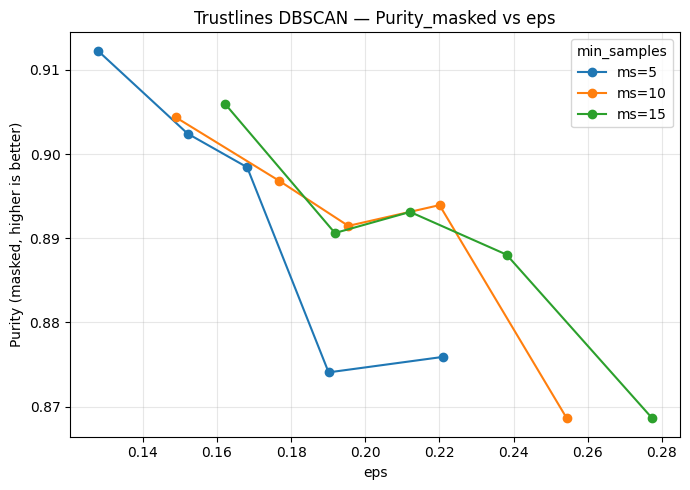

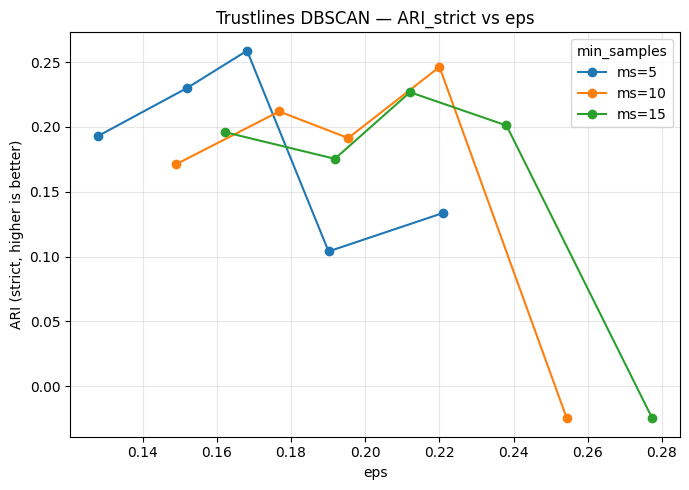

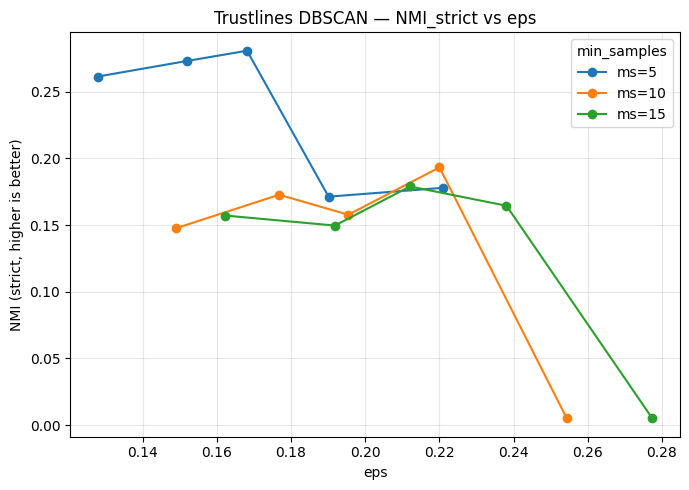

In [ ]:
extr = pd.read_csv("trustlines/evaluation_res/trustlines_dbscan_extrinsic_scores_kgrid_test.csv")

eps_col = "eps_value" if "eps_value" in extr.columns else "eps"

has_ms = "min_samples" in extr.columns and extr["min_samples"].notna().any()
groups = extr.groupby("min_samples") if has_ms else [(None, extr)]

def plot_metric(metric_col, ylabel, title):
    plt.figure(figsize=(7,5))
    for ms, df in groups:
        df = df.sort_values(eps_col)
        df = df[np.isfinite(df[eps_col]) & np.isfinite(df[metric_col])]
        if df.empty:
            continue
        label = f"ms={int(ms)}" if ms is not None and not np.isnan(ms) else None
        plt.plot(df[eps_col], df[metric_col], marker="o", label=label)
    plt.xlabel("eps")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, which="both", axis="both", alpha=0.3)
    if has_ms:
        plt.legend(title="min_samples")
    plt.tight_layout()
    plt.show()

plot_metric("ARI_masked",
            "ARI (masked, higher is better)",
            "Trustlines DBSCAN — ARI_masked vs eps")

plot_metric("NMI_masked",
            "NMI (masked, higher is better)",
            "Trustlines DBSCAN — NMI_masked vs eps")

plot_metric("Purity_masked",
            "Purity (masked, higher is better)",
            "Trustlines DBSCAN — Purity_masked vs eps")



plot_metric("ARI_strict",
            "ARI (strict, higher is better)",
            "Trustlines DBSCAN — ARI_strict vs eps")

plot_metric("NMI_strict",
            "NMI (strict, higher is better)",
            "Trustlines DBSCAN — NMI_strict vs eps")


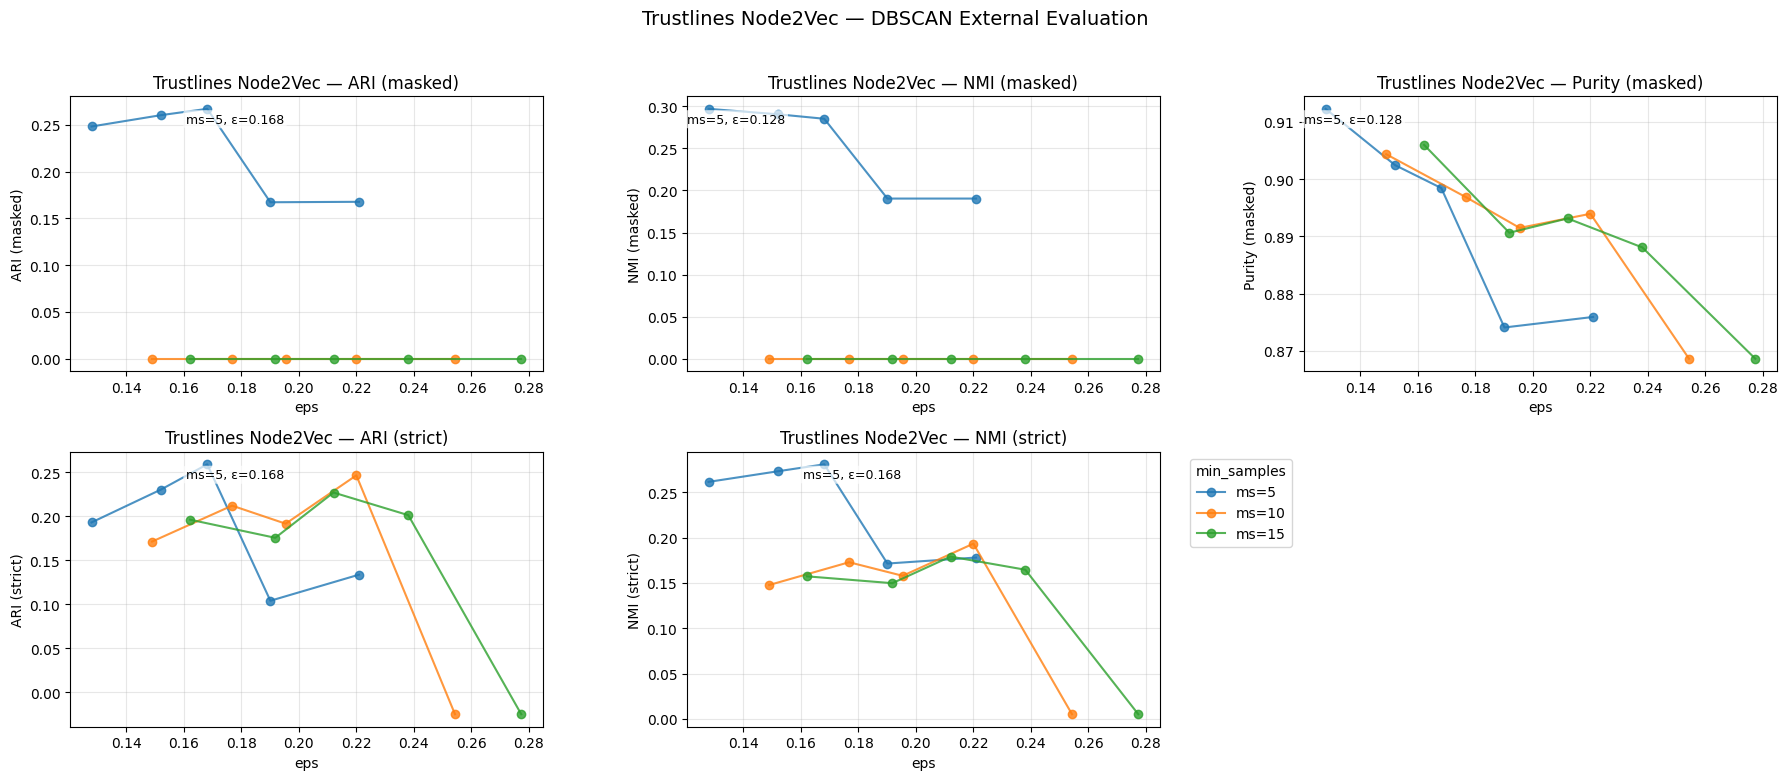

In [553]:
plot_external_all(extr, title_prefix="Trustlines Node2Vec")